In [22]:
#основное
import pandas as pd
import numpy as np

#модели
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import mixture

#метрики
import scipy as sp
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

#визуализация
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

In [23]:
pip install wordcloud

You should consider upgrading via the 'd:\soft\python\python.exe -m pip install --upgrade pip' command.


# Рекомендательная система для аниме

In [24]:
anime = pd.read_csv('./data/anime.csv')
rating = pd.read_csv('./data/rating.csv')

Есть база пользователей и база объектов:

In [25]:
rating['user_id'].unique()

array([    1,     2,     3, ..., 73514, 73515, 73516], dtype=int64)

In [26]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


Есть фидбек (у нас оценки пользователей):

In [27]:
rating['rating'].unique()

array([-1, 10,  8,  6,  9,  7,  3,  5,  4,  1,  2], dtype=int64)

Задача - порекоммендовать пользователю что-то, что ему понравится:

In [28]:
#вырежем аниме, которым 500-ый человек в таблице поставил высшую оценку
user_500 = rating[rating['user_id'] == 500][rating['rating'] == 10]
name = []
ep = []
typ = []
genre = []
def best_for_500(what, where):
    for i in user_500['anime_id']:
        for j in anime[anime['anime_id'] == i][what]:
            where.append(j)
            
best_for_500('name', name)
best_for_500('episodes', ep)
best_for_500('type', typ)
best_for_500('genre', genre)

<ipython-input-28-fd80f48e616d>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  user_500 = rating[rating['user_id'] == 500][rating['rating'] == 10]


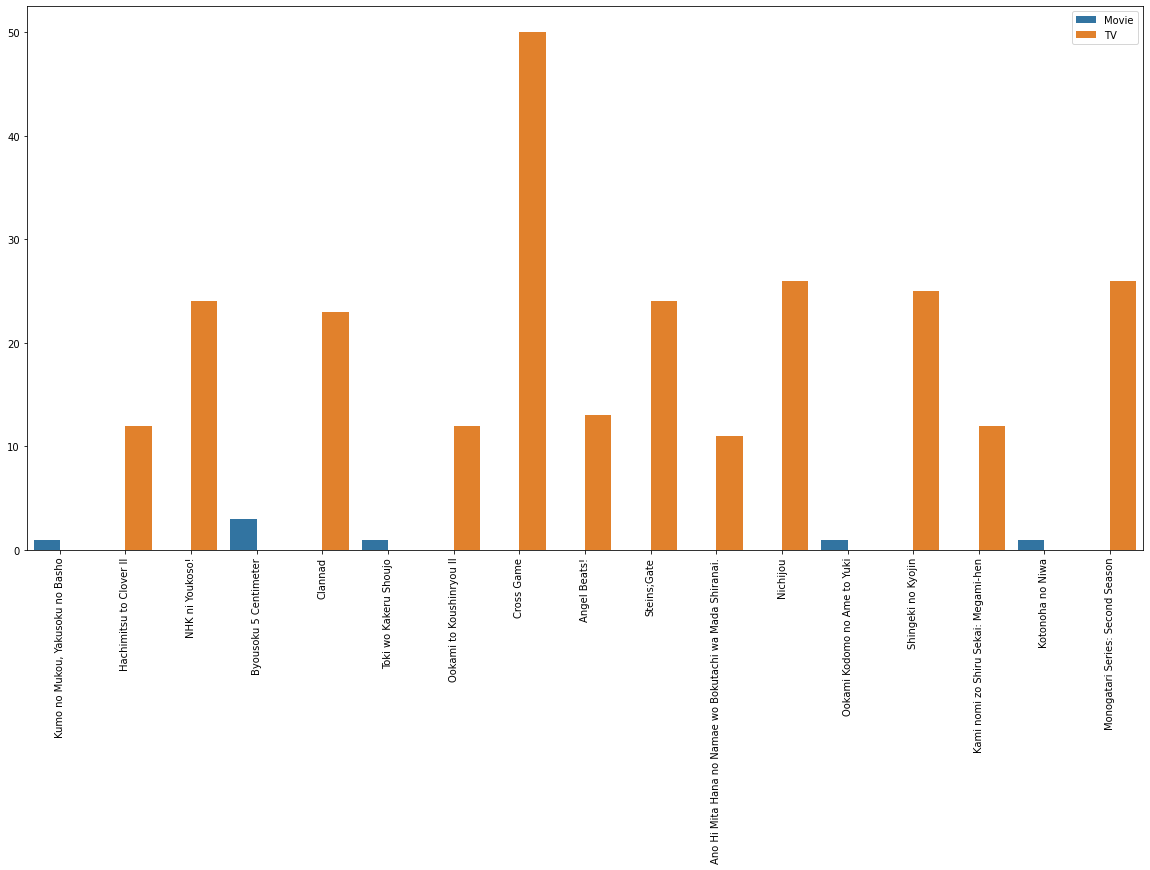

In [29]:
#в основном смотрит небольшие сериалы
f, ax = plt.subplots(figsize=(20, 10))
sns.barplot(x=name, y=list(map(lambda x: int(x), ep)), hue=typ)
for label in ax.get_xticklabels():
    label.set_rotation('vertical')

In [30]:
print(anime[anime['name'] == 'Ginga Eiyuu Densetsu'].rating)
print(rating[rating['anime_id'] == 820].rating.mean())

7    9.11
Name: rating, dtype: float64
8.23920265780731


In [31]:
# средний рейтинг аниме выводился на основе каких-то других данных, тк он отличается от среднего по пользователям в датасете
print(anime[anime['name'] == 'Serial Experiments Lain'].rating)
print(rating[rating['anime_id'] == 339].rating.mean())

540    7.99
Name: rating, dtype: float64
6.702277568408979


In [32]:
popular = anime[anime['rating'] >= 9]
popular.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


## Preprocessing

Подготовим данные:

"-1" - нет оценки:

In [33]:
rating['rating'].replace({-1: np.nan}, inplace = True)
rating.head()

,user_id,anime_id,rating
0,1,20,NaN
1,1,24,NaN
2,1,79,NaN
3,1,226,NaN
4,1,241,NaN


In [143]:
merged = pd.merge(anime,rating,on='anime_id')
merged = merged.rename({'rating_y':'user_rating', 'rating_x':'rating'}, axis='columns')
merged.head()

,anime_id,name,genre,type,episodes,rating,members,user_id,user_rating
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5.0
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10.0
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10.0
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10.0
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,278,NaN


Для колаборативной фильтрации нужен только фидбек и название, поэтому разделим датасеты

In [144]:
merged_clust = merged.copy()
merged_colab = merged[['user_id', 'name', 'user_rating']]

In [145]:
merged_colab.head()

,user_id,name,user_rating
0,99,Kimi no Na wa.,5.0
1,152,Kimi no Na wa.,10.0
2,244,Kimi no Na wa.,10.0
3,271,Kimi no Na wa.,10.0
4,278,Kimi no Na wa.,NaN


In [149]:
merged_clust[merged_clust['user_id'] == 5]

,anime_id,name,genre,type,episodes,rating,members,user_id,user_rating
28159,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,5,9.0
47442,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,5,9.0
61826,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534,5,10.0
64351,15417,Gintama&#039;: Enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",TV,13,9.11,81109,5,8.0
84786,918,Gintama,"Action, Comedy, Historical, Parody, Samurai, S...",TV,201,9.04,336376,5,9.0
...,...,...,...,...,...,...,...,...,...
7612269,1685,Duel Masters,"Action, Adventure, Comedy, Shounen",TV,26,5.92,13012,5,NaN
7615190,8619,Ladies versus Butlers! Tokuten Disc Music Clip,"Ecchi, Music",Special,1,5.90,5676,5,2.0
7636779,9741,Nana to Kaoru,"Comedy, Ecchi, Romance, Seinen",OVA,1,5.79,12919,5,2.0
7650287,13479,Uchuu Kyoudai: Apo&#039;s Dream,"Comedy, Sci-Fi, Space",OVA,1,5.62,2323,5,6.0


In [150]:
len(anime['name'].unique())

12292

In [151]:
len(merged_clust['anime_id'].unique())

11196

In [ ]:
merged_clust['user_id'].unique()

In [152]:
merged_clust.shape

(7813727, 9)

In [ ]:
uni = []
for i in merged_clust['user_id'].unique():
    uni.append(merged_clust[merged_clust['user_id'] == i]['name'].count())

In [103]:
np.mean(uni)

1.900433320398396

In [112]:
merged_clust['episodes'].astype('int').mean()

52.97711378447821

## Выбор модели

### 1. Кластеризация пользователей: 

https://www.kaggle.com/tanetboss/user-clustering-for-anime-recommendation 
1. Лайком будет считаться rating mean, не превосходящий rating от оценки сериала.

In [37]:
rating_mean = merged_clust.groupby(['user_id']).mean().reset_index()
merged_clust['mean_rating'] = rating_mean['rating']

In [38]:
merged_clust.dropna(inplace=True)

In [39]:
merged_clust.head()

,anime_id,name,genre,type,episodes,rating,members,user_id,user_rating,mean_rating
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5.0,7.436405
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10.0,7.993333
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10.0,7.726702
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10.0,7.681923
5,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,322,10.0,7.630811


In [40]:
merged_clust = merged_clust.drop(merged_clust[merged_clust.user_rating < merged_clust.mean_rating].index)
merged_clust.head()

,anime_id,name,genre,type,episodes,rating,members,user_id,user_rating,mean_rating
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10.0,7.993333
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10.0,7.726702
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10.0,7.681923
5,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,322,10.0,7.630811
6,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,398,10.0,7.439125


Что происходит в новом датасете: там лежат "лайки" - средняя оценка пользователя vs оценка

Где: rating - средняя по аниме; userRating - уникальная для пользователя; mean_rating - средняя по пользователю

2. Посмотрим теперь поближе на сериалы, которые понравились конкретному пользователю.

In [41]:
user_anime = pd.crosstab(merged['user_id'], merged['name'])
user_anime.head()

name,&quot;0&quot;,"&quot;Aesop&quot; no Ohanashi yori: Ushi to Kaeru, Yokubatta Inu",&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,&quot;Bungaku Shoujo&quot; Memoire,&quot;Bungaku Shoujo&quot; Movie,&quot;Eiji&quot;,.hack//G.U. Returner,.hack//G.U. Trilogy,.hack//G.U. Trilogy: Parody Mode,.hack//Gift,...,makemagic,"on-chan, Yume Power Daibouken!",s.CRY.ed,vivi,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki,◯
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [42]:
user_anime[user_anime['Serial Experiments Lain'] == 1]

name,&quot;0&quot;,"&quot;Aesop&quot; no Ohanashi yori: Ushi to Kaeru, Yokubatta Inu",&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,&quot;Bungaku Shoujo&quot; Memoire,&quot;Bungaku Shoujo&quot; Movie,&quot;Eiji&quot;,.hack//G.U. Returner,.hack//G.U. Trilogy,.hack//G.U. Trilogy: Parody Mode,.hack//Gift,...,makemagic,"on-chan, Yume Power Daibouken!",s.CRY.ed,vivi,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki,◯
user_id,,,,,,,,,,,,,,,,,,,,,
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73485,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1,0,0,0
73494,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
73502,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,1,1,0,1,0


### PCA

In [43]:
model = PCA(n_components=3)
model.fit(user_anime)
pca_samples = model.transform(user_anime)

In [44]:
ps = pd.DataFrame(pca_samples)
ps.head()

,0,1,2
0,2.627204,-3.368708,3.274517
1,-2.705089,-0.520659,0.448784
2,0.093874,-1.750977,-2.152310
3,-0.858801,-0.454554,0.283246
4,9.118652,-2.662283,2.257524


In [45]:
print(f'Было {user_anime.shape}, стало {ps.shape}')

Было (73515, 11196), стало (73515, 3)


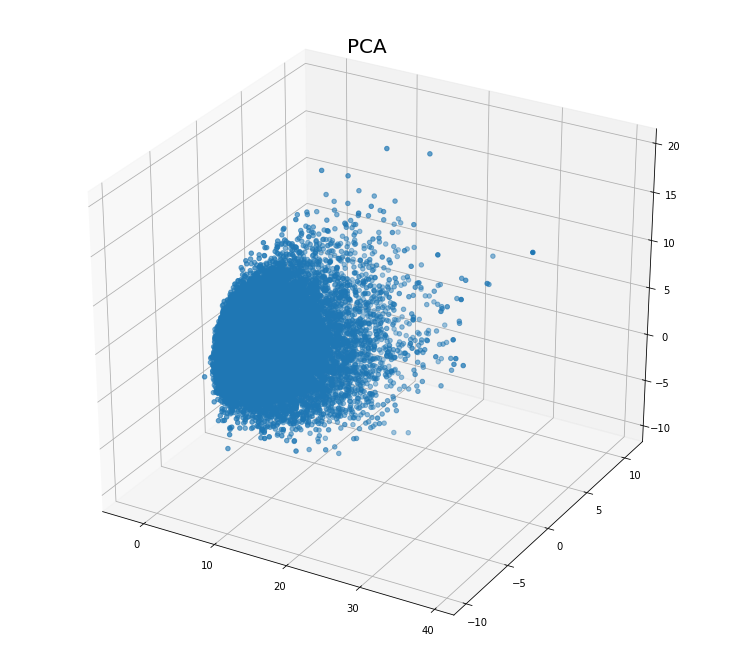

In [46]:
tocluster = pd.DataFrame(ps[[0,1,2]])
plt.rcParams['figure.figsize'] = (10, 9)


fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(tocluster[0], tocluster[2], tocluster[1])

plt.title('PCA', fontsize=20)
plt.show()

### Кластеризуем

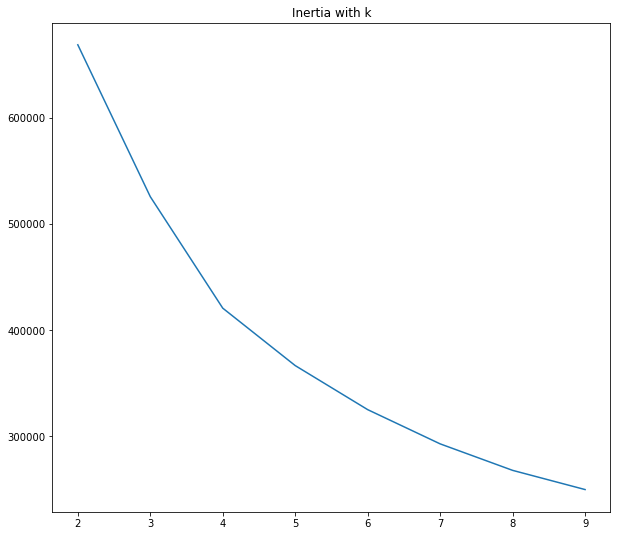

In [47]:
plt.plot(range(2,10),[KMeans(n_clusters=k).fit(tocluster).inertia_ for k in range(2,10)])
plt.title('Inertia with k');

In [48]:
lowest_bic = np.infty
bic = []
n_components_range = range(1, 10)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(tocluster)
        bic.append(gmm.bic(tocluster))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
            best_cv = cv_type

In [49]:
print(best_gmm)
print(best_cv)

GaussianMixture(n_components=9)
full


In [50]:
kmeans = KMeans(n_clusters=4,random_state=17).fit(tocluster)
gmm = mixture.GaussianMixture(n_components=8, covariance_type='full').fit(tocluster)

In [51]:
kmeans_pred = kmeans.predict(tocluster)
gmm_pred = gmm.predict(tocluster)

In [52]:
def show_clusters(title, clusters, clusters_predicted):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(clusters[0], clusters[2], clusters[1], c = clusters_predicted)
    plt.title(title)
    plt.show()

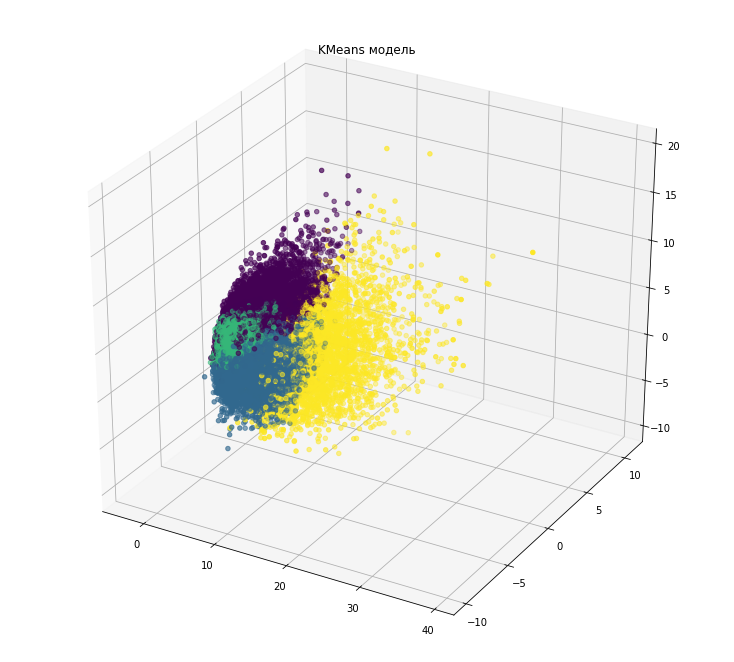

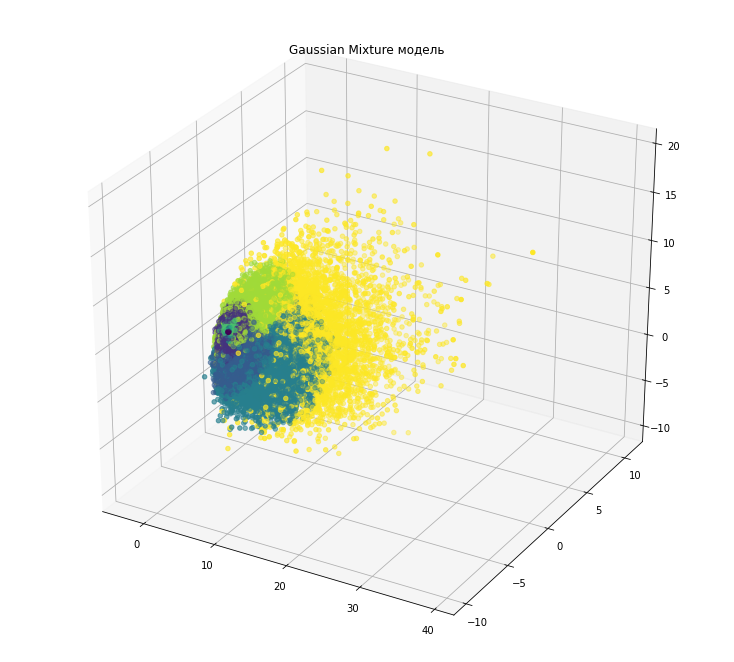

In [53]:
show_clusters('KMeans модель', tocluster, kmeans_pred)
show_clusters('Gaussian Mixture модель', tocluster, gmm_pred)

In [54]:
user_anime['kmeans'] = kmeans_pred
user_anime['gmm'] = gmm_pred

In [123]:
print(f'Силуэт KMeans: {silhouette_score(tocluster, kmeans_pred)}')
print(f'Силуэт Gaussian Mixture: {silhouette_score(tocluster, gmm_pred)}')

Силуэт KMeans: 0.5038525804431297
Силуэт Gaussian Mixture: 0.10587779345624135


### Что всё это значит?

И дальше можно смотреть еще какие жанры входят...

In [55]:
merged_clust.set_index(merged_clust['user_id'], drop=True, inplace=True)
merged_clust.head()

,anime_id,name,genre,type,episodes,rating,members,user_id,user_rating,mean_rating
user_id,,,,,,,,,,
152,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10.0,7.993333
244,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10.0,7.726702
271,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10.0,7.681923
322,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,322,10.0,7.630811
398,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,398,10.0,7.439125


Теперь у нас как будто размеченные данные!

In [56]:
after_clustering = pd.merge(merged_clust, user_anime[['kmeans', 'gmm']], left_index=True, right_index=True).drop(columns='user_id')
after_clustering.head()

,anime_id,name,genre,type,episodes,rating,members,user_rating,mean_rating,kmeans,gmm
user_id,,,,,,,,,,,
3,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,10.0,7.434534,1,2
5,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,9.0,7.935750,3,7
5,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,9.0,7.648310,3,7
5,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534,10.0,7.534301,3,7
5,15417,Gintama&#039;: Enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",TV,13,9.11,81109,8.0,7.745000,3,7


In [59]:
def assign_cluster_vars(method, number):
    return after_clustering[after_clustering[method]==number].drop(columns=['kmeans', 'gmm'])

def assign_cluster_means(method, number):
    return user_anime[user_anime[method]==number].drop(columns=['kmeans', 'gmm']).mean()

In [61]:
print(assign_cluster_means('kmeans', 3).sort_values(ascending=False)[0:15])

name
Sword Art Online                                       0.936400
Angel Beats!                                           0.928734
Toradora!                                              0.908291
Boku wa Tomodachi ga Sukunai                           0.871948
Highschool of the Dead                                 0.866553
Hataraku Maou-sama!                                    0.853492
Bakemonogatari                                         0.852073
No Game No Life                                        0.847814
Shingeki no Kyojin                                     0.843839
Kore wa Zombie Desu ka?                                0.838444
Chuunibyou demo Koi ga Shitai!                         0.837876
Ore no Imouto ga Konnani Kawaii Wake ga Nai            0.837592
Code Geass: Hangyaku no Lelouch                        0.834185
Yahari Ore no Seishun Love Comedy wa Machigatteiru.    0.829642
Kami nomi zo Shiru Sekai                               0.825951
dtype: float64


In [ ]:
print(assign_cluster_means('gmm', 0).sort_values(ascending=False)[0:15])
print(assign_cluster_means('gmm', 2).sort_values(ascending=False)[0:15])
print(assign_cluster_means('kmeans', 0).sort_values(ascending=False)[0:15])
print(assign_cluster_means('kmeans', 3).sort_values(ascending=False)[0:15])

In [65]:
kmeans_0, kmeans_1, kmeans_2, kmeans_3 = assign_cluster_vars('kmeans', 0), assign_cluster_vars('kmeans', 1), assign_cluster_vars('kmeans', 2), assign_cluster_vars('kmeans', 3)
gmm_0, kmeans_1, gmm_2, gmm_3, gmm_4, gmm_5, gmm_6, gmm_7 = assign_cluster_vars('gmm', 0), assign_cluster_vars('gmm', 1), assign_cluster_vars('gmm', 2), assign_cluster_vars('gmm', 3), assign_cluster_vars('gmm', 4), assign_cluster_vars('gmm', 5), assign_cluster_vars('gmm', 6), assign_cluster_vars('gmm', 7)

In [66]:
def freq_dict(df, genres_all):
    for i in df['genre'].values:
        for j in i.split():
            genres_all.append(j.strip(','))

    genres_for_freq = []      
    for i in genres_all:
        word_count = genres_all.count(i)
        genres_for_freq.append((i,word_count))       

    frequency = dict(genres_for_freq)
    return frequency

In [67]:
genres_0_all = []
genres_2_all = []

kmeans_0_frequency = freq_dict(kmeans_0, genres_0_all)
kmeans_2_frequency = freq_dict(kmeans_2, genres_2_all)

In [68]:
genres_0_all = []
genres_2_all = []

gmm_0_frequency = freq_dict(gmm_0, genres_0_all)
gmm_2_frequency = freq_dict(gmm_2, genres_2_all)

In [69]:
def freq_dict_names(df):
    names_for_freq = []      
    for i in df['name'].values:
        word_count = list(df['name'].values).count(i)
        names_for_freq.append((i,word_count))       

    frequency = dict(names_for_freq)
    return frequency

А генератор облачков написал А.Мюллер: https://github.com/amueller/word_cloud

In [70]:
def cloud(name, dictionary):
    wordcloud = WordCloud(
                      width=1500,
                      height=500, 
                      background_color="lemonchiffon", 
                      max_words=20,
                      max_font_size=500, 
                      normalize_plurals=False).generate_from_frequencies(dictionary)
    plt.title(name)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

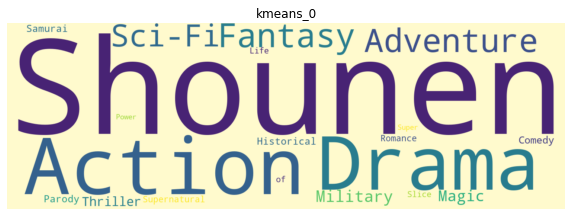

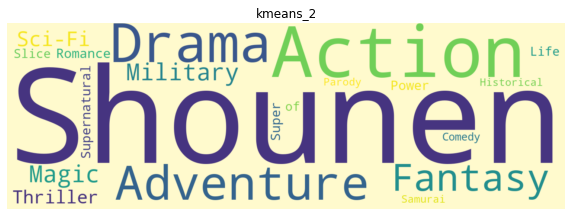

In [71]:
cloud('kmeans_0', kmeans_0_frequency)
cloud('kmeans_2', kmeans_2_frequency)

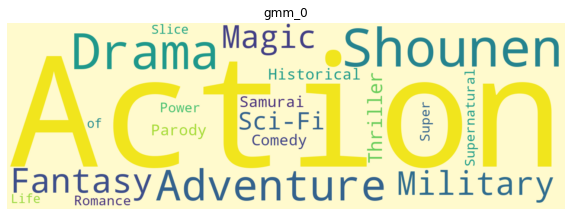

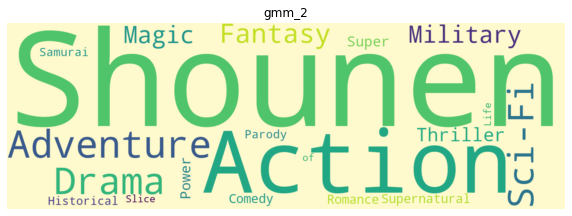

In [72]:
cloud('gmm_0', gmm_0_frequency)
cloud('gmm_2', gmm_2_frequency)

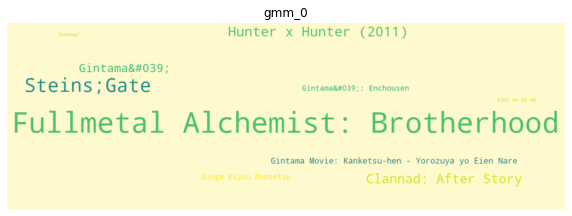

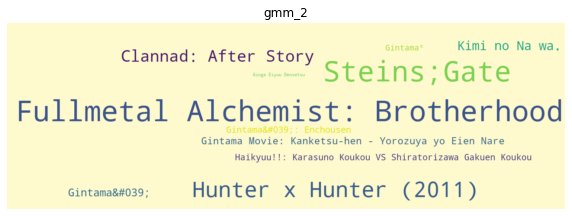

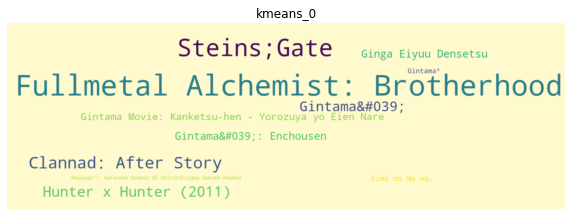

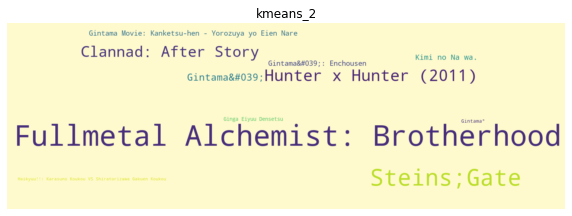

In [73]:
gmm_0_name_frequency = freq_dict_names(gmm_0)
cloud('gmm_0', gmm_0_name_frequency)
gmm_2_name_frequency = freq_dict_names(gmm_2)
cloud('gmm_2', gmm_2_name_frequency)
kmeans_0_name_frequency = freq_dict_names(kmeans_0)
cloud('kmeans_0', kmeans_0_name_frequency)
kmeans_2_name_frequency = freq_dict_names(kmeans_2)
cloud('kmeans_2', kmeans_2_name_frequency)

In [ ]:
predicted_rating('Cowboy Bebop', 3)